In [ ]:
# !pip install tensorflow==2.4.1
# !pip install keras==2.3.1

In [ ]:
import os
import sys
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import re
import time
import datetime
import nltk

from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding, CuDNNGRU
from tensorflow.keras.models import Model
from tensorflow.python.keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.python.training import training
from tensorflow.python.client import device_lib
from google.colab import drive
from google.colab import files
from tqdm import tqdm

In [ ]:
try:
  drive.mount('/content/drive')
  os.chdir("drive/My Drive/GoogleColab/")
  print('Dosya dizini belirtilen konuma ayarlandı.')
except:
  print('Dosya dizini belirtilen konumda...')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dosya dizini belirtilen konuma ayarlandı.


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Jul 12 16:57:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
try:
  %load_ext tensorboard
  print("TensorBoard eklentisi kuruldu.")
finally:
  %rm -rf ./logs/
  print("Önceki çalıştırmalardan elde edilen günlükler temizlendi.")

TensorBoard eklentisi kuruldu.
Önceki çalıştırmalardan elde edilen günlükler temizlendi.


In [ ]:
if tf.executing_eagerly():
  print("İstekli çalışma modu çalışıyor.")
else:
  tf.compat.v1.enable_eager_execution()
  print("İstekli çalışma moduna geçildi.")

İstekli çalışma modu çalışıyor.


In [ ]:
print("TensorFlow version: {}".format(tf.__version__))
print("Keras version: {}".format(keras.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow version: 2.8.2
Keras version: 2.8.0
Eager execution: True


### **Verileri Yükleme**

In [ ]:
# document = pd.read_csv('preparedSuDerDataset.csv')
# document.drop(['Unnamed: 0'], axis=1, inplace=True)

# news_texts = document['News']
# title_texts = document['Title']

# series_news_texts = pd.Series(news_texts)
# series_title_texts = pd.Series(title_texts)

In [ ]:
documentPre = pd.read_csv('documentRevV2_3.csv')
documentPre.drop(['Unnamed: 0'], axis=1, inplace=True)
document = documentPre[:125000]

news_texts = document['News']
title_texts = document['Title']

series_news_texts = pd.Series(news_texts)
series_title_texts = pd.Series(title_texts)

In [ ]:
series_news_texts[114189]

"TÜSİAD'ın yeni yönetim kurulu Davos'ta görmeye alıştığımız bir düzende basının karşısına çıktı. Üyeler, Muharrem Yılmaz, Cansen Başaran, Haluk Dinçer, Boyner, Tayfun Bayazıt, Volkan Vural ve Mehmet Ali .Aydınlar toplantıya katıldı. Lucien Arkas, Ali Kibar ve Erman Ilıcak ilk toplantıda yoktu."

## **Eğitim Öncesi Ön İşlemler**


---


Haber ve Başlıklar için Metin Ön İşleme Aşaması

Vektörizasyon, sekans uzunluklarının dolgulanması, vektörleri tensörlere dönüştürme ve dataset'in yığın halinde ayarlanması işlemleri...

In [ ]:
with open("TurkishStopWords.txt",mode="r") as tsw:
  stopWords = tsw.read()
  stopWords = stopWords.split("\n")

In [ ]:
def news_preprocess(row):
  # Sıra önemli
  # Tarihleri silmek için (05.11.1994) (5 Kasım 1994)
  row = re.sub("(([0-9]+(\.)[0-9]+(\.)[0-9]+)|([0-9]+.(ocak|şubat|mart|nisan|mayıs|haziran|temmuz|ağustos|eylül|ekim|kasım|aralık).[0-9]+)|([0-9]+.(ocak|şubat|mart|nisan|mayıs|haziran|temmuz|ağustos|eylül|ekim|kasım|aralık)))\S+", "", row, flags=re.IGNORECASE)
  row=re.sub(r"([0-9]+)", ' ', str(row))
  row = re.sub("([Hh][Aa][Bb][Ee][Rr][İi][Nn] [Dd][Ee][Vv][Aa][Mm][Iı])\W+"," ",str(row)) # 'Haberin Devamı' yazan haberleri temizler 
  row=re.sub("([Kk]aynak: [abcçdefghıijklmnoöprsştuüvyzABCÇDEFGHIİJKLMNOÖPRSŞTUÜVYZ])\w+", ' ', str(row)) 
  row=re.sub("([İi]şte [Dd]etaylar)\W+", ' ', str(row))
  row=re.sub(r"(([ABCÇDEFGĞHIİJKLMNOÖPRSŞTUÜVYZ]{2,})+ ([ABCÇDEFGĞHIİJKLMNOÖPRSŞTUÜVYZ]{2,})+ ([ABCÇDEFGĞHIİJKLMNOÖPRSŞTUÜVYZ]{2,}))\w+", ' ', str(row)) # Ara başlıkları silmek için.
  row=re.sub(r"(([ABCÇDEFGĞHIİJKLMNOÖPRSŞTUÜVYZ]{2,})+ ([ABCÇDEFGĞHIİJKLMNOÖPRSŞTUÜVYZ]{2,}))\w+", ' ', str(row)) # Ara başlıkları silmek için.
  row = re.sub("(İ)","i",str(row)) # Büyük İ sorunu için ASCII karşlığı yok
  row = re.sub("(I)","ı",str(row)) # Büyük I sorunu için ASCII karşlığı yok
  row=re.sub("(\\t)", ' ', str(row)) # Tab'ları tek boşluk yapmak için
  row=re.sub("(\\n)", ' ', str(row))
  row=re.sub("(\\r)", ' ', str(row))
  row = re.sub("(\s+)",' ',str(row)) # Birden fazla boşluğu tek boşluğa düşürmek için
  row=re.sub("(__+)", ' ', str(row))
  row=re.sub("(--+)", ' ', str(row))
  row=re.sub("(~~+)", ' ', str(row))
  row=re.sub("(\+\++)", ' ', str(row))
  row=re.sub("(\.\.+)", ' ', str(row))
  row=re.sub(r"[<>(){|}&©ø\[\]\'\",;:?~*!#$%‘’+-.=@`]", ' ', str(row)) # Karakter temizliği
  row=re.sub(r"[()]\S+", ' ', str(row)) # Parantez içini silmek için
  # Çok sayıları tek sayı biçimine düşürmek için
  row=re.sub(r"([0-9]+)", ' ', str(row))
  # row=re.sub("(###)\W+", '### ', str(row))
  row = re.sub("(\s+)",' ',str(row)) # Birden fazla boşluğu tek boşluğa düşürmek için
  row=re.sub(r"(\s+.\s+)\w+", ' ', str(row))
  row = re.sub("(\s+)",' ',str(row))
  row = row.strip() # Metinin sağ ve sol tarafındaki boşluğu silmek için
  row = row.lower()

  words_list = row.split()
  filtered_stop_words = [word for word in words_list if word not in stopWords]
  filtered_words = [word for word in filtered_stop_words if len(word)>2]

  row = " ".join(filtered_words)

  return row

In [ ]:
def title_preprocess(row):
  # Sıra önemli
  row = re.sub("(İ)","i",str(row)) # Büyük İ sorunu için ASCII karşlığı yok
  row = re.sub("(I)","ı",str(row)) # Büyük I sorunu için ASCII karşlığı yok
  row=re.sub("(\\t)", ' ', str(row)) # Tab'ları tek boşluk yapmak için
  row=re.sub("(\\n)", ' ', str(row))
  row=re.sub("(\\r)", ' ', str(row))
  row = re.sub("(\s+)",' ',str(row)) # Birden fazla boşluğu tek boşluğa düşürmek için
  row=re.sub("(__+)", ' ', str(row))
  row=re.sub("(--+)", ' ', str(row))
  row=re.sub("(~~+)", ' ', str(row))
  row=re.sub("(\+\++)", ' ', str(row))
  row=re.sub("(\.\.+)", ' ', str(row))
  row=re.sub(r"[<>(){|}&©ø\[\]\'\",;:?~*!#$%‘’+-.=@`]", ' ', str(row)) # Karakter temizliği
  row=re.sub(r"[()]\S+", ' ', str(row)) # Parantez içini silmek için
  # Çok sayıları tek sayı biçimine düşürmek için
  row=re.sub(r"([0-9]+)", '###', str(row))
  row=re.sub("(###)\W+", '### ', str(row))
  row = re.sub("(\s+)",' ',str(row)) # Birden fazla boşluğu tek boşluğa düşürmek için
  row=re.sub(r"(\s+.\s+)\w+", ' ', str(row))
  row = re.sub("(\s+)",' ',str(row))
  row = row.strip() # Metinin sağ ve sol tarafındaki boşluğu silmek için
  row = row.lower()
 
  return row

**Dataset Train ve Validation Olarak Bölme**




---



In [ ]:
_ISTART_ = '<istart> '
_IEND_ = ' <iend>'

_TSTART_ = '<tstart> '
_TEND_ = ' <tend>'

tqdm.pandas(desc="Progress")

series_news_texts = series_news_texts.progress_apply(lambda x: _ISTART_ + news_preprocess(str(x)) + _IEND_).astype(str)
series_title_texts = series_title_texts.progress_apply(lambda x: _TSTART_ + title_preprocess(str(x)) + _TEND_).astype(str)

Progress: 100%|██████████| 125000/125000 [00:03<00:00, 33406.54it/s]


In [ ]:
#Input ve Output'a göre vektörleri hazırlama
encoder_maxlen = 384
decoder_maxlen = 14

short_text = []
short_summary = []

for i in range(len(series_news_texts)):
    if(len(series_title_texts[i].split())<=decoder_maxlen and len(series_news_texts[i].split())<=encoder_maxlen):
        short_text.append(series_news_texts[i])
        short_summary.append(series_title_texts[i])

short_text_series = pd.Series(short_text)
short_summary_series = pd.Series(short_summary)

news_train, news_validation, title_train, title_validation = train_test_split(short_text_series, short_summary_series, test_size=0.1, shuffle=False)

In [ ]:
len(series_news_texts), len(short_text_series), len(series_title_texts), len(short_summary_series)

(125000, 115812, 125000, 115812)

In [ ]:
# news_train, news_validation, title_train, title_validation = train_test_split(series_news_texts, series_title_texts, test_size=0.1)

**Metinleri tokenlere(jeton, vektör) Dönüştürme**

---



In [ ]:
# '<' ve '>' varsayılan belirteçlerden kaldırılamaz. Çünkü dekoder için hedef derlemimizi bu işaretler arasına aldık
# Gerekli olan filtreleme işlemini news_preprocess ve title_preprocess fonksionlarıyla yaptık
filters = '!"$%()*+,./:;=?@[\\]^_{|}~\t\n'

In [ ]:
#news_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=filters)
#title_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=filters)
news_tokenizer = keras.preprocessing.text.Tokenizer(filters=filters)
title_tokenizer = keras.preprocessing.text.Tokenizer(filters=filters)

In [ ]:
print("Haber metinlerinin vektör sözlüğü oluşturuluyor...")
news_tokenizer.fit_on_texts(news_train)
print("Haber metinlerinin vektör sözlüğü oluşturuldu.")

print("Haber başlıklarının vektör sözlüğü oluşturuluyor...")
title_tokenizer.fit_on_texts(title_train)
# title_tokenizer.fit_on_texts(title_train)
print("Haber başlıklarının vektör sözlüğü oluşturuldu.")
# --------------------------------------------------------------------
# print("Haber metinlerinin vektör sözlüğü oluşturuluyor...")
# news_tokenizer.fit_on_texts(series_news_texts)
# print("Haber metinlerinin vektör sözlüğü oluşturuldu.")

# print("Haber başlıklarının vektör sözlüğü oluşturuluyor...")
# news_tokenizer.fit_on_texts(series_title_texts)
# print("Haber başlıklarının vektör sözlüğü oluşturuldu.")

Haber metinlerinin vektör sözlüğü oluşturuluyor...
Haber metinlerinin vektör sözlüğü oluşturuldu.
Haber başlıklarının vektör sözlüğü oluşturuluyor...
Haber başlıklarının vektör sözlüğü oluşturuldu.


In [ ]:
print("Haber metinleri vektörleştiriliyor...")
inputs = news_tokenizer.texts_to_sequences(news_train)
print("Haber metinleri vektörleştirildi.")

print("Haber başlıkları vektörleştiriliyor...")
# targets = news_tokenizer.texts_to_sequences(title_train)
targets = title_tokenizer.texts_to_sequences(title_train)
print("Haber başlıkları vektörleştirildi.")

Haber metinleri vektörleştiriliyor...
Haber metinleri vektörleştirildi.
Haber başlıkları vektörleştiriliyor...
Haber başlıkları vektörleştirildi.


In [ ]:
encoder_vocab_size = len(news_tokenizer.word_index) + 1 
decoder_vocab_size = len(title_tokenizer.word_index) + 1
# decoder_vocab_size = len(news_tokenizer.word_index) + 1

print('Encoder sözlük sayısı: {}\nDecoder sözlük sayısı: {}'.format(encoder_vocab_size, decoder_vocab_size))

Encoder sözlük sayısı: 418733
Decoder sözlük sayısı: 57317


**Haber ve başlık metinlerinin ayrı ayrı uzunluklarını tanımlama**

In [ ]:
# news_train_lengths = pd.Series([len(x.split()) for x in news_train])
# title_train_lengths = pd.Series([len(x.split()) for x in title_train])

# news_validation_lengths = pd.Series([len(x.split()) for x in news_validation])
# title_validation_lengths = pd.Series([len(x.split()) for x in title_validation])

In [ ]:
encoder_maxlen = 384
decoder_maxlen = 14

In [ ]:
inputs = tf.keras.preprocessing.sequence.pad_sequences(
    inputs,
    maxlen=encoder_maxlen,
    padding='post',
    truncating='post')

targets = tf.keras.preprocessing.sequence.pad_sequences(
    targets,
    maxlen=decoder_maxlen,
    padding='post',
    truncating='post')

In [ ]:
# tf.cast almış olduğu x vektör dizisini (bu kod bloğunda inputs ve targets) tensör olarak döndürür. Tensörler numpy() dizileri gibi düşünülebilir
encoder_input_data = inputs
decoder_input_data = targets[:, :-1]
decoder_output_data = targets[:, 1:]

inputs = tf.cast(encoder_input_data, dtype=tf.int32)
decoder_input_data = tf.cast(decoder_input_data, dtype=tf.int32)
decoder_output_data = tf.cast(decoder_output_data, dtype=tf.int32)

In [ ]:
BATCH_SIZE = 256
EMBEDDING_SIZE = 480 # Sözlük boyutu (dimension)
STATE_SIZE = 400 # Katmanlar arası nöron sayısı

In [ ]:
encoder_embedding = Embedding(input_dim = encoder_vocab_size, output_dim = EMBEDDING_SIZE, name = 'encoder_embedding')

In [ ]:
# encoder_gru1 = GRU(STATE_SIZE, name='encoder_gru1', return_sequences = True)
# encoder_gru2 = GRU(STATE_SIZE, name='encoder_gru2', return_sequences = True)
# encoder_gru3 = GRU(STATE_SIZE, name='encoder_gru3', return_sequences = False)

In [ ]:
encoder_gru1 = CuDNNGRU(STATE_SIZE, name='encoder_gru1', return_sequences = True)
encoder_gru2 = CuDNNGRU(STATE_SIZE, name='encoder_gru2', return_sequences = True)
encoder_gru3 = CuDNNGRU(STATE_SIZE, name='encoder_gru3', return_sequences = False)

In [ ]:
encoder_input = Input(shape=(None,), name='encoder_input')

In [ ]:
def connect_encoder():
    net = encoder_input
    net = encoder_embedding(net)
    
    net = encoder_gru1(net)
    net = encoder_gru2(net)
    net = encoder_gru3(net)
    
    encoder_output = net
    
    return encoder_output

In [ ]:
encoder_output = connect_encoder()

In [ ]:
decoder_initial_state = Input(shape=(STATE_SIZE,), name='decoder_initial_size')

In [ ]:
decoder_input = Input(shape=(None,), name='decoder_input')

In [ ]:
decoder_embedding = Embedding(input_dim=decoder_vocab_size, output_dim=EMBEDDING_SIZE, name='decoder_embedding')

In [ ]:
# decoder_gru1 = GRU(STATE_SIZE, name='decoder_gru1', return_sequences=True)
# decoder_gru2 = GRU(STATE_SIZE, name='decoder_gru2', return_sequences=True)
# decoder_gru3 = GRU(STATE_SIZE, name='decoder_gru3', return_sequences=True) 

In [ ]:
decoder_gru1 = CuDNNGRU(STATE_SIZE, name='decoder_gru1', return_sequences=True)
decoder_gru2 = CuDNNGRU(STATE_SIZE, name='decoder_gru2', return_sequences=True)
decoder_gru3 = CuDNNGRU(STATE_SIZE, name='decoder_gru3', return_sequences=True)

In [ ]:
decoder_dense = Dense(decoder_vocab_size, activation='linear', name='decoder_output')

In [ ]:
def connect_decoder(initial_state):
    net = decoder_input
    
    net = decoder_embedding(net)
    
    net = decoder_gru1(net, initial_state=initial_state)
    net = decoder_gru2(net, initial_state=initial_state)
    net = decoder_gru3(net, initial_state=initial_state)
    
    decoder_output = decoder_dense(net)
    
    return decoder_output

In [ ]:
decoder_output = connect_decoder(initial_state=encoder_output)

In [ ]:
model_train = Model(inputs=[encoder_input, decoder_input], outputs=[decoder_output])

In [ ]:
model_encoder = Model(inputs=[encoder_input], outputs=[encoder_output])

In [ ]:
decoder_output = connect_decoder(initial_state=decoder_initial_state)

model_decoder = Model(inputs=[decoder_input, decoder_initial_state], outputs=[decoder_output])

In [ ]:
def sparse_cross_entropy(y_true, y_pred):
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred)
    loss_mean = tf.reduce_mean(loss)
    return loss_mean

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [ ]:
model_train.compile(optimizer=optimizer, loss=sparse_cross_entropy, metrics=['accuracy'], run_eagerly=True)

In [ ]:
checkpoint_path = "checkpoints/rev2/gru/metrics/train/"
checkpoint = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True)

In [ ]:
latest = tf.train.latest_checkpoint(checkpoint_path)

In [ ]:
try:
    model_train.load_weights(checkpoint_path)
except Exception as error:
    print('Checkpoint yüklenirken hata oluştu. Eğitime başlanıyor...\n')
    print(error)

Checkpoint yüklenirken hata oluştu. Eğitime başlanıyor...

Unsuccessful TensorSliceReader constructor: Failed to find any matching files for checkpoints/rev2/gru/metrics/train/


In [ ]:
# model_train.load_weights(checkpoint_path)

In [ ]:
x_data = {'encoder_input':inputs, 'decoder_input':decoder_input_data}
y_data = {'decoder_output':decoder_output_data}

In [ ]:
callbacks = tf.keras.callbacks.TensorBoard(log_dir='checkpoints/rev2/gru/metrics', histogram_freq=1, write_graph=True, write_images=False, update_freq='epoch', profile_batch=2, embeddings_freq=1, embeddings_metadata=None)

In [ ]:
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=1)

In [ ]:
# model_train.save_weights(checkpoint_path.format(epoch=0))

In [ ]:
print(latest)

None


In [ ]:
model_train.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
encoder_embedding (Embedding)   (None, None, 480)    200991840   encoder_input[0][0]              
__________________________________________________________________________________________________
encoder_gru1 (CuDNNGRU)         (None, None, 400)    1058400     encoder_embedding[0][0]          
__________________________________________________________________________________________________
decoder_input (InputLayer)      [(None, None)]       0                                            
______________________________________________________________________________________________

In [ ]:
# model_train = keras.models.load_model('./checkpoints/rev2/gru/metrics/train/keras_embedding.ckpt-24.data-00000-of-00001')

In [ ]:
# !ls

In [ ]:
history = model_train.fit(x=x_data, y=y_data, batch_size=BATCH_SIZE, epochs=25, callbacks=callbacks)

Epoch 1/25
408/408 [==============================] - 1197s 3s/step - loss: 4.6313 - accuracy: 0.5532
Epoch 2/25
408/408 [==============================] - 1195s 3s/step - loss: 3.4193 - accuracy: 0.6156
Epoch 3/25
408/408 [==============================] - 1192s 3s/step - loss: 3.2439 - accuracy: 0.6230
Epoch 4/25
408/408 [==============================] - 1197s 3s/step - loss: 2.9560 - accuracy: 0.6363
Epoch 5/25
408/408 [==============================] - 1195s 3s/step - loss: 2.7068 - accuracy: 0.6472
Epoch 6/25
408/408 [==============================] - 1193s 3s/step - loss: 2.5043 - accuracy: 0.6572
Epoch 7/25
408/408 [==============================] - 1193s 3s/step - loss: 2.3326 - accuracy: 0.6658
Epoch 8/25
408/408 [==============================] - 1193s 3s/step - loss: 2.1632 - accuracy: 0.6760
Epoch 9/25
408/408 [==============================] - 1193s 3s/step - loss: 2.0128 - accuracy: 0.6858
Epoch 10/25
408/408 [==============================] - 1197s 3s/step - loss: 1.872

In [ ]:
model_train.save(checkpoint_path)
print("{}. Epoch Model Kaydedildi...".format(i+1))

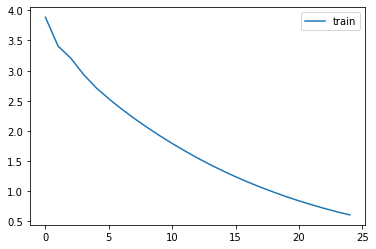

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
# pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
# x_val_seq   =  news_tokenizer.texts_to_sequences(news_validation)
# #padding zero upto maximum length
# x_val   =   pad_sequences(x_val_seq, maxlen=encoder_maxlen, padding='post')

# #size of vocabulary ( +1 for padding token)
# x_voc   =  len(news_tokenizer.word_counts)+1

# print("Size of vocabulary in X = {}".format(x_voc))

# #prepare a tokenizer for reviews on training data
# #convert text sequences into integer sequences (i.e one hot encode the text in Y)
# y_val_seq   =   title_tokenizer.texts_to_sequences(title_validation) 

# #padding zero upto maximum length
# y_val   =   pad_sequences(y_val_seq, maxlen=decoder_maxlen, padding='post')

# #size of vocabulary
# y_voc  =   len(title_tokenizer.word_counts)+1
# print("Size of vocabulary in Y = {}".format(y_voc))

In [ ]:
# inputs_val = tf.keras.preprocessing.sequence.pad_sequences(
#     x_val,
#     maxlen=encoder_maxlen,
#     padding='post',
#     truncating='post')

# targets_val = tf.keras.preprocessing.sequence.pad_sequences(
#     y_val,
#     maxlen=decoder_maxlen,
#     padding='post',
#     truncating='post')

# encoder_input_data_val = inputs_val
# decoder_input_data_val = targets_val[:, :-1]
# decoder_output_data_val = targets_val[:, 1:]

# inputs_val = tf.cast(encoder_input_data_val, dtype=tf.int32)
# decoder_input_data_val = tf.cast(decoder_input_data_val, dtype=tf.int32)
# decoder_output_data_val = tf.cast(decoder_output_data_val, dtype=tf.int32)

# x_data_val = {'encoder_input_val':inputs_val, 'decoder_input_val':decoder_input_data_val}
# y_data_val = {'decoder_output_val':decoder_output_data_val}

In [ ]:
# loss, accuracy = model_train.evaluate(x_val,y_val)
# print(f"Accuracy: {accuracy * 100:.2f}%")
# print(f"Loss: {loss * 100:.2f}%")

In [ ]:
history_dict = history.history

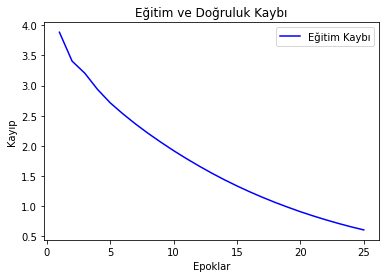

In [ ]:
loss_values = history_dict['loss']
# val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values,'b',label='Eğitim Kaybı')#bo mavi nokta için
# plt.plot(epochs, val_loss_values, 'b', label='Doğruluk Kaybı')#b mavi düz çizgi için
plt.title('Eğitim ve Doğruluk Kaybı')
plt.xlabel('Epoklar')
plt.ylabel('Kayıp')
plt.legend()

plt.show()

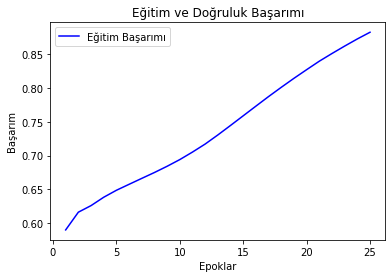

In [ ]:
plt.clf()#Şekli temizler

acc = history_dict['accuracy']
# val_acc = history_dict['val_acc']

plt.plot(epochs, acc,'b',label='Eğitim Başarımı')#bo mavi nokta için
# plt.plot(epochs, val_acc, 'b', label='Doğruluk Başarımı')#b mavi düz çizgi için
plt.title('Eğitim ve Doğruluk Başarımı')
plt.xlabel('Epoklar')
plt.ylabel('Başarım')
plt.legend()

plt.show()

## **Değerlendirme**

In [ ]:
token_start = title_tokenizer.word_index[_TSTART_.strip()]
token_end = title_tokenizer.word_index[_TEND_.strip()]

In [ ]:
def generate(input_text, true_output_text=None):

  input_tokens = news_tokenizer.texts_to_sequences([input_text])
  input_tokens = np.array(input_tokens)

  initial_state = model_encoder.predict(input_tokens)

  decoder_input_data = np.zeros(shape=(1,decoder_maxlen), dtype=np.int32)

  token_int = token_start
  output_text=' '
  count_tokens=0

  while token_int != token_end and count_tokens < decoder_maxlen:
    decoder_input_data[0, count_tokens] = token_int
    x_data = {'decoder_input':decoder_input_data, 'decoder_initial_size':initial_state}

    decoder_output = model_decoder.predict(x_data)

    token_onehot = decoder_output[0, count_tokens,:]
    token_int = np.argmax(token_onehot)

    sample_word = title_tokenizer.index_word[token_int]
    output_text += ' '+sample_word
    count_tokens+= 1

  # print('Girdi:')
  # print(input_text)
  # print()

  # print('Üretililen Başlık:')
  # print(output_text)
  # print()

  # print('Gerçek Başlık:')
  # print(true_output_text)
  # print()

  return output_text

In [ ]:
# token_int = token_start
# count_tokens = 0

In [ ]:
print(title_tokenizer.word_index["<tstart> ".strip()])
print(title_tokenizer.word_index["<tend> ".strip()])

In [ ]:
# sample_word = title_tokenizer.index_word[token_int]

In [ ]:
# token_onehot = decoder_output[0, count_tokens,:]
# token_int = np.argmax(token_onehot)

In [ ]:
news_val = []

for i, news_v in enumerate(news_validation):
  temp=str(news_v)
  news_val.append(temp)
  
news_val

In [ ]:
title_val = []

for i, title_v in enumerate(title_validation):
  temp=str(title_v)
  title_val.append(temp)
  
title_val

In [ ]:
generated_titles.clear()

In [ ]:
generated_titles = []

for i in range(len(news_val)):
  generated_title = generate(news_val[i], title_val[i])
  generated_titles.append(str(generated_title))

In [ ]:
news_val_series = pd.Series(news_val)
title_val_series = pd.Series(title_val)
genererated_titles_series = pd.Series(generated_titles)

In [ ]:
dict_validation_generated = {"News":news_val_series , "OriginalTitle":title_val_series, "Predictions":genererated_titles_series}
df_validation_generated = pd.DataFrame(dict_validation_generated)
df_validation_generated.to_csv("GeneratedTitlesGRU.csv")

In [ ]:
os.listdir()

['checkpoints',
 'Documents',
 'pureDocument_256_6.csv',
 'train_document.csv',
 'myMetric',
 'ytu_kemik_news_dataset.csv',
 'f25k.csv',
 's25k.csv',
 'f25k25e.csv',
 's25k25e.csv',
 'preparedSuDerDataset2.csv',
 'preparedSuDerDataset.csv',
 'TurkishStopWords.txt',
 'dataTrainRevV2_3.csv',
 'dataValidationRevV2_3.csv',
 'documentRevV2_3.csv',
 'lstm_model.h5',
 'GeneratedTitlesGRU.csv']

In [ ]:
# dict_validation_generated = {"News":news_validation , "OriginalTitle":title_validation, "Predictions":generated_titles}
# df_validation_generated = pd.DataFrame(dict_validation_generated)
# df_validation_generated.to_csv("GeneratedTitlesGRU.csv")

In [ ]:
index = 39546
generate(news_texts[index],true_output_text=title_texts[index])

## **Compute Score**

### **BLEU**

In [ ]:
!pip install --upgrade bleu
from bleu import list_bleu

In [ ]:
ref = ["""thy nin yolcu sayısı ### milyona ulaştı"""]
hyp = ["""THY yolcu sayısını 9.2 milyona çıkardı"""]

In [ ]:
list_bleu([ref], hyp)



---



In [ ]:
import nltk

In [ ]:
hypothesis = "### terörist etkisiz hale getirildi".split()
reference = title_preprocess("Bitlis'te 6 teröristin öldürüldüğü operasyonda çok sayıda silah mühimmat ele geçirildi").split()
#there may be several references
BLEUscore = nltk.translate.bleu_score.sentence_bleu([reference], hypothesis,auto_reweigh=True)
print(BLEUscore*100)



---



In [ ]:
# two references for one document
from nltk.translate.bleu_score import corpus_bleu
references = [["".split()]]
candidates = ["".split(), "".split()]
score = corpus_bleu(references, candidates)
print(score)

### **ROUGE**

In [ ]:
!pip install 0 0 

In [ ]:
from rouge_metric import PyRouge

By default, sentences are separated by '\n' and tokens are separated by white space in a document. This tokenization process can be further customized. For example,

In [ ]:
# # Template
# from rouge_metric import PyRouge

# # Pre-process and tokenize the summaries as you like
# hypotheses = [
#     ['how are you'.split(), 'i am fine'.split()],                       # document 1: hypothesis
#     ['it is fine today'.split(), 'we won the football game'.split()],   # document 2: hypothesis
# ]
# references = [[
#     ['how do you do'.split(), 'fine thanks'.split()],   # document 1: reference 1
#     ['how old are you'.split(), 'i am three'.split()],  # document 1: reference 2
# ], [
#     ['it is sunny today'.split(), 'let us go for a walk'.split()],  # document 2: reference 1
#     ['it is a terrible day'.split(), 'we lost the game'.split()],   # document 2: reference 2
# ]]

# # Evaluate on tokenized documents
# rouge = PyRouge(rouge_n=(1, 2, 4), rouge_l=True, rouge_w=True,
#                 rouge_w_weight=1.2, rouge_s=True, rouge_su=True, skip_gap=4)
# scores = rouge.evaluate_tokenized(hypotheses, references)
# print(scores)

In [ ]:
# hypotheses = ["kavga ### can alan maganda vurdu".split()]
# references = ["Kavga sebebi sudan faturası ise iki can".split()]

In [ ]:
# print(hypotheses)
# print(references)

In [ ]:
# references = [title.split() for title in title_texts]

In [ ]:
# hypotheses20 = [generate_title(news_preprocess(news)).split() for news in news_texts]

In [ ]:
# hypotheses20 = news_texts.progress_apply(lambda x: generate_title(news_preprocess(str(x))) if i < range(25000))

In [ ]:
hypotheses25 = []
references = []

# tqdm.pandas(desc="Progress")
# for i in tqdm(range(25000,52489)):
#   hypotheses20.append(generate_title(news_preprocess(news_texts[i])).split())
#   references.append(title_texts[i].split())

In [ ]:
dict_rouge = {"Tahmin - 25 Epoch":hypotheses25}

In [ ]:
df = pd.DataFrame(dict_rouge)

In [ ]:
df.to_csv("s25k25e.csv")

In [ ]:
for i in tqdm(range(25000,52489)):
  hypotheses25.append(generate_title(news_preprocess(news_texts[i])))